## Imports

In [1]:
import os
import io
import re
import cv2 
import subprocess
import time
import uuid
import pathlib
from datetime import datetime

import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

import csv
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

from object_detection.builders import model_builder
from object_detection.utils import config_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util

In [ ]:
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
base_config_path = './pipeline.config'

configs = config_util.get_configs_from_pipeline_file(base_config_path)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

print("Model was successfully built")

Model was successfully built


In [2]:
#Checking for gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.10.1


## Setup

In [3]:
random.seed(42)
np.random.seed(21)
tf.compat.v1.random.set_random_seed(42)

In [ ]:
# Id_mapping:
    # 1:'Speed limit (30km/h)', 
    # 2:'Speed limit (50km/h)',
    # 12:'Priority road', 
    # 14:'Stop', 
    # 17:'No entry',
    # 41:'Ende des Überholverbots',

In [4]:
SAMPLE_SIZE_TRAIN = 50 # Default: 50 Images of each class excluding values in :id_mapping. Used for Trainset
SAMPLE_SIZE_TEST = 10 # Default: 10 Images of each class excluding values in :id_mapping . Used for Testset

IMAGE_WIDTH = 280 # Image width in pixels to resize for visualization
IMAGE_HEIGHT = 280 # Image height in pixels to resize for visualization

train_path = './GTSRB/Final_Training/Images' # Location of the training images
test_path = './GTSRB/Final_Test/Images' # Location of the test images

id_mapping = {1: 1, 2: 2, 12: 3, 14: 4, 17: 5}
unknown_label = 6

In [6]:
BASE_MODEL = "ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8"
MODEL_NAME = "SSD_8000_640_mobilenet_v2_fpnlite"
IS_SSD = True # True if SSD model is used. False otherwise 

BATCH_SIZE = 12
NUM_CLASSES = 5
NUM_STEPS = 8000
NUM_EVAL_STEPS = 1000
use_bfloat16 = False # Use bfloat16 True for TPU

NOTES = "" # Training Notes for the log 

In [7]:
# Used for Evaluation
if IS_SSD:
    TRAINED_CONFIG_PATH = "./myModules/configs/{name}_config.config".format(name=MODEL_NAME)
    TRAINED_CHECKPOINT_PATH = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'.format(name=MODEL_NAME)
    TRAINED_LABLE_MAP_PATH = "./myModules/label_map_short.pbtxt"
else:
    TRAINED_CONFIG_PATH = "./myModules/configs/{name}_config.config".format(name=MODEL_NAME)
    TRAINED_CHECKPOINT_PATH = 'D:\\Desktop-Short\\trained_models\\faster_rcnn\\{name}'.format(name=MODEL_NAME)
    TRAINED_LABLE_MAP_PATH = "./myModules/label_map_short.pbtxt"

In [8]:
# Used for Training and Inference
if IS_SSD:
    # Download from path 
    base_config_path = "./base_models/ssd/{name}/pipeline.config".format(name=BASE_MODEL)
    base_checkpoint_path = "./base_models/ssd/{name}/checkpoint/ckpt-0".format(name=BASE_MODEL)

    # Save to path
    model_dir = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'.format(name=MODEL_NAME)
    config_path = './myModules/configs/{name}_config.config'.format(name=MODEL_NAME)

    # Upload from path
    labelmap_path = "./myModules/label_map_short_woUnk.pbtxt"
    train_record_path = "./myModules/records/trainWoUnknown.record"
    test_record_path = "./myModules/records/testWoUnknown.record"
    
    inference_path = './inference/ssd/{name}'.format(name=MODEL_NAME)
else:
    base_config_path = "D:\\Desktop-Short\\base_models\\faster_rcnn\\{name}\\pipeline.config".format(name=BASE_MODEL)
    base_checkpoint_path = "D:\\Desktop-Short\\base_models\\{name}\\checkpoint\\ckpt-0".format(name=BASE_MODEL)

    # Save to path
    model_dir = 'D:\\Desktop-Short\\trained_models\\faster_rcnn\\{name}'.format(name=MODEL_NAME)
    config_path = './myModules/configs/{name}_config.config'.format(name=MODEL_NAME)

    # Upload from path
    labelmap_path = "./myModules/label_map_short.pbtxt"
    train_record_path = "./myModules/records/train.record"
    test_record_path = "./myModules/records/test.record"
    
    inference_path = './inference/faster_rcnn/{name}'.format(name=MODEL_NAME)

## 1. Dataset

### Dataset Setup

In [9]:
def readTrafficSignsTrain(rootpath, cache_path):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments:
        rootpath: path to the traffic sign data, for example './GTSRB/Training'
        cache_path: path to the cached DataFrame file, default is 'traffic_signs_data.pkl'
    Returns:
        DataFrame containing labels, image shapes, ROIs, and image paths
    '''
    
    if os.path.exists(cache_path):
        print(f"Loading: {cache_path}")
        return pd.read_pickle(cache_path)

    data = []
    # loop over all 43 classes
    for c in range(0, 43):
        prefix = f"{rootpath}/{c:05d}/"  # subdirectory for class
        gtFile = open(prefix + f'GT-{c:05d}.csv')  # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
        next(gtReader)  # skip header

        # loop over all images in current annotations file
        for row in gtReader:
            img_path = prefix + row[0]
            img = plt.imread(img_path)  # load image
 
            label = int(row[7])  # the 8th column is the label
            height = img.shape[0]  # height of the image
            width = img.shape[1]  # width of the image
            #channels = img.shape[2] if len(img.shape) > 2 else 1  # channels of the image (default to 1 if grayscale)
            roi_x1 = int(row[3])  # ROI X1 coordinate
            roi_y1 = int(row[4])  # ROI Y1 coordinate
            roi_x2 = int(row[5])  # ROI X2 coordinate
            roi_y2 = int(row[6])  # ROI Y2 coordinate

            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])

        gtFile.close()

    df = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    
    df.to_pickle(cache_path)
    print(f"Dataframe saved in: {cache_path}")
    
    return df

In [10]:
def readTrafficSignsTest(rootpath, cache_path):
    '''Reads the final test data for the German Traffic Sign Recognition Benchmark.
    Arguments: path to the final test data, for example './GTSRB/Final_Test/Images'
    Returns: DataFrame with image data, labels, image shapes, and ROI
    '''
    
    if os.path.exists(cache_path):
        print(f"Loading: {cache_path}")
        return pd.read_pickle(cache_path)

    # Pfad zur CSV-Datei
    csv_file = os.path.join(rootpath, 'GT-final_test_gt.csv')
    
    # Lade die CSV-Datei
    df = pd.read_csv(csv_file, delimiter=';')
    
    # Liste zum Speichern der Daten
    data = []
    
    # Schleife über alle Zeilen der CSV-Datei
    for _, row in df.iterrows():
        img_path = os.path.join(rootpath, row['Filename'])
        img = plt.imread(img_path)  # Lade das Bild
        
        if img is not None:
            label = int(row['ClassId'])
            height, width, channels = img.shape
            roi_x1 = int(row['Roi.X1'])
            roi_y1 = int(row['Roi.Y1'])
            roi_x2 = int(row['Roi.X2'])
            roi_y2 = int(row['Roi.Y2'])
            
            # Füge die Daten als Zeile hinzu
            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])
        else:
            print(f"Bild {img_path} konnte nicht geladen werden.")
    
    # Erstelle ein DataFrame aus der Liste
    df_test = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    df_test.to_pickle(cache_path)
    print(f"Dataframe saved in: {cache_path}")
    return df_test

In [11]:
def load_image_into_numpy_array(path):
    image = Image.open(path)
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize to 280x280
    return np.array(image).astype(np.uint8)

In [12]:
def reassign_labels(df, selected_labels, unknown_label, sample_size):
    """
    Reassign labels in the dataframe according to selected_labels.
    Keep all rows for the labels in selected_labels.
    For remaining labels, sample a specified number of rows and reassign them to unknown_label.

    Parameters:
    df (pd.DataFrame): The input dataframe with a column named 'Label'.
    selected_labels (dict): A dictionary mapping old labels to new labels.
    unknown_label (int): The label to assign to the remaining sampled rows.
    sample_size (int): The number of rows to sample for each remaining label. Default is 15.

    Returns:
    pd.DataFrame: A new dataframe with reassigned labels.
    """
    new_df = pd.DataFrame()

    for old_label, new_label in selected_labels.items():
        label_df = df[df['Label'] == old_label].copy()
        label_df['Label'] = new_label
        new_df = pd.concat([new_df, label_df])

    unique_labels = df['Label'].unique()
    remaining_labels = [label for label in unique_labels if label not in selected_labels]

    for label in remaining_labels:
        label_df = df[df['Label'] == label]
        if len(label_df) > sample_size:
            selected_rows = label_df.sample(n=sample_size, random_state=42)
        else:
            selected_rows = label_df
        selected_rows['Label'] = unknown_label
        new_df = pd.concat([new_df, selected_rows])

    new_df.reset_index(drop=True, inplace=True)

    return new_df

### 1.0 Dataset for YOLO

In [13]:
PATH_TO_TRAIN_DF = "./myModules/data/df_train_raw.pkl"
PATH_TO_TEST_DF = "./myModules/data/df_test_raw.pkl"

PATH_TO_TRAIN_ANNOTATIONS = './yoloNoUnkData/Train/Annotations/'
PATH_TO_TRAIN_IMAGES = './yoloNoUnkData/Train/Images/'

PATH_TO_TEST_ANNOTATIONS = './yoloNoUnkData/Test/Annotations/'
PATH_TO_TEST_IMAGES = './yoloNoUnkData/Test/'

In [14]:
def prettify_xml(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

In [15]:
def create_voc_annotation_for_trainset(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for index, row in df.iterrows():
        annotation = ET.Element('annotation')
        
        # Extract subfolder name (e.g., '0000')
        subfolder_name = os.path.basename(os.path.dirname(row['Path']))
        
        # Create unique filename with subfolder prefix (e.g., '0000_00000_00000.xml')
        os.path.basename(row['Path']).replace('.ppm', '.jpg')
        filename = f"{subfolder_name}_{os.path.splitext(os.path.basename(row['Path']))[0]}.xml"
        
        # Create annotation elements
        ET.SubElement(annotation, 'folder').text = 'Images'
        ET.SubElement(annotation, 'filename').text = filename.replace('.xml', '.jpg')
        
        size = ET.SubElement(annotation, 'size')
        ET.SubElement(size, 'width').text = str(row['Width'])
        ET.SubElement(size, 'height').text = str(row['Height'])
        ET.SubElement(size, 'depth').text = '3'  # Assuming RGB images

        segmented = ET.SubElement(annotation, 'segmented').text = '0'
        
        obj = ET.SubElement(annotation, 'object')
        ET.SubElement(obj, 'name').text = str(row['Label'])
        ET.SubElement(obj, 'pose').text = 'Unspecified'
        ET.SubElement(obj, 'truncated').text = '0'
        ET.SubElement(obj, 'difficult').text = '0'
        
        bndbox = ET.SubElement(obj, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(row['Roi.X1'])
        ET.SubElement(bndbox, 'ymin').text = str(row['Roi.Y1'])
        ET.SubElement(bndbox, 'xmax').text = str(row['Roi.X2'])
        ET.SubElement(bndbox, 'ymax').text = str(row['Roi.Y2'])
        
        # Write XML file with pretty print
        output_file = os.path.join(output_dir, filename)
        with open(output_file, 'w') as f:
            f.write(prettify_xml(annotation))

In [16]:
def create_voc_annotation_for_testset(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in df.iterrows():
        annotation = ET.Element('annotation')
        ET.SubElement(annotation, 'folder').text = 'Images'
        ET.SubElement(annotation, 'filename').text = os.path.basename(row['Path']).replace('.ppm', '.jpg')
        
        size = ET.SubElement(annotation, 'size')
        ET.SubElement(size, 'width').text = str(row['Width'])
        ET.SubElement(size, 'height').text = str(row['Height'])
        ET.SubElement(size, 'depth').text = '3'  # Assuming RGB images

        segmented = ET.SubElement(annotation, 'segmented').text = '0'
        
        obj = ET.SubElement(annotation, 'object')
        ET.SubElement(obj, 'name').text = str(row['Label'])
        ET.SubElement(obj, 'pose').text = 'Unspecified'
        ET.SubElement(obj, 'truncated').text = '0'
        ET.SubElement(obj, 'difficult').text = '0'
        
        bndbox = ET.SubElement(obj, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(row['Roi.X1'])
        ET.SubElement(bndbox, 'ymin').text = str(row['Roi.Y1'])
        ET.SubElement(bndbox, 'xmax').text = str(row['Roi.X2'])
        ET.SubElement(bndbox, 'ymax').text = str(row['Roi.Y2'])
        
        # Write XML file with pretty print
        output_file = os.path.join(output_dir, os.path.basename(row['Path']).replace('.ppm', '.xml'))
        with open(output_file, 'w') as f:
            f.write(prettify_xml(annotation))

In [17]:
def convert_ppm_to_jpg_from_df_train(df, jpg_root):
    if not os.path.exists(jpg_root):
        os.makedirs(jpg_root)
    
    for index, row in df.iterrows():
        img_path = row['Path']
        if img_path.endswith('.ppm'):
            img = Image.open(img_path)
            
            # Extrahiere den Dateinamen und den Subordner aus dem Pfad
            folder_name = os.path.basename(os.path.dirname(img_path))  # Subordner
            filename = os.path.basename(img_path).replace('.ppm', '.jpg')
            jpg_filename = f"{folder_name}_{filename}"  # Füge den Subordner-Namen vor dem Dateinamen hinzu
            
            # Erstelle den Ziel-JPEG-Pfad
            jpg_path = os.path.join(jpg_root, jpg_filename)
            
            # Speichere das Bild im JPEG-Format
            img.save(jpg_path, 'JPEG')

In [18]:
def convert_ppm_to_jpg_from_df(df, jpg_dir):
    if not os.path.exists(jpg_dir):
        os.makedirs(jpg_dir)
    
    for index, row in df.iterrows():
        img_path = row['Path']
        if img_path.endswith('.ppm'):
            img = Image.open(img_path)
            # Extrahiere den Dateinamen und den Unterordner aus dem Pfad
            subfolder = os.path.basename(os.path.dirname(img_path))
            filename = os.path.basename(img_path).replace('.ppm', '.jpg')
            # Erstelle den Zielpfad inklusive Unterordner
            jpg_subdir = os.path.join(jpg_dir, subfolder)
            if not os.path.exists(jpg_subdir):
                os.makedirs(jpg_subdir)
            jpg_path = os.path.join(jpg_subdir, filename)
            img.save(jpg_path, 'JPEG')

In [26]:
#df = readTrafficSignsTrain(train_path, PATH_TO_TRAIN_DF)
create_voc_annotation_for_trainset(df_final_train, PATH_TO_TRAIN_ANNOTATIONS)
convert_ppm_to_jpg_from_df_train(df_final_train, PATH_TO_TRAIN_IMAGES)

In [25]:
#df = readTrafficSignsTest(test_path, PATH_TO_TEST_DF)
create_voc_annotation_for_testset(df_final_test, PATH_TO_TEST_ANNOTATIONS)
convert_ppm_to_jpg_from_df(df_final_test, PATH_TO_TEST_IMAGES)

### 1.1 Dataset export 

In [13]:
df_train_cache = readTrafficSignsTrain(train_path, "./myModules/data/df_train_raw.pkl")
df_train = pd.DataFrame()
df_train = df_train_cache.copy()

Loading: ./myModules/data/df_train_raw.pkl


In [14]:
df_test_cache = readTrafficSignsTest(test_path, "./myModules/data/df_test_raw.pkl")
df_test = pd.DataFrame()
df_test = df_test_cache.copy()

Loading: ./myModules/data/df_test_raw.pkl


In [15]:
df_final_train = reassign_labels(df_train, id_mapping, unknown_label, SAMPLE_SIZE_TRAIN)
df_final_test = reassign_labels(df_test, id_mapping, unknown_label, SAMPLE_SIZE_TEST)

In [16]:
# Run to exlude the unknown Labels
df_final_train = df_final_train[df_final_train['Label'] != 6]
df_final_test = df_final_test[df_final_test['Label'] != 6]

In [17]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2790 entries, 0 to 2789
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Width   2790 non-null   int64 
 1   Height  2790 non-null   int64 
 2   Roi.X1  2790 non-null   int64 
 3   Roi.Y1  2790 non-null   int64 
 4   Roi.X2  2790 non-null   int64 
 5   Roi.Y2  2790 non-null   int64 
 6   Path    2790 non-null   object
 7   Label   2790 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 196.2+ KB


In [17]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8460 entries, 0 to 8459
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Width   8460 non-null   int64 
 1   Height  8460 non-null   int64 
 2   Roi.X1  8460 non-null   int64 
 3   Roi.Y1  8460 non-null   int64 
 4   Roi.X2  8460 non-null   int64 
 5   Roi.Y2  8460 non-null   int64 
 6   Path    8460 non-null   object
 7   Label   8460 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 594.8+ KB


### 1.2 Verfify Dataset

In [ ]:
%matplotlib inline
short_classes = { 1: 'Geschwindigkeitsbegrenzung (30km/h)', 
                  2: 'Geschwindigkeitsbegrenzung (50km/h)', 
                  3: 'Vorrangstraße', 
                  4: 'Stop', 
                  5: 'Einfahrt verboten',
                  6: 'Unbekannt'}

In [ ]:
image_paths_to_display = df_final_train['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()

In [ ]:
image_paths_to_display = df_final_test['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()

In [ ]:
unknown_label_df = df_final_train[df_final_train['Label'] == 6]

# Wähle zufällig 100 Bilder aus
image_paths_to_display = unknown_label_df['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

# Plotten der ausgewählten Bilder
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
label_counts_final = df_final_train['Label'].value_counts().sort_index()

num_classes = len(label_counts_final)

label_counts_named_final = {short_classes[key]: value for key, value in label_counts_final.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_final.keys()), y=list(label_counts_named_final.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Trainingsdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

In [ ]:
label_counts_test = df_final_test['Label'].value_counts().sort_index()
label_counts_train = df_final_train['Label'].value_counts().sort_index()

num_classes = len(label_counts_test)

In [ ]:
label_counts_named_train = {short_classes[key]: value for key, value in label_counts_train.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_train.keys()), y=list(label_counts_named_train.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Trainingsdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

In [ ]:
label_counts_named_test = {short_classes[key]: value for key, value in label_counts_test.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_test.keys()), y=list(label_counts_named_test.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Testdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

### 1.3 Create Tf-records

In [ ]:
def create_tf_example(row):
    img_path = row['Path']
    # Lade das Bild und konvertiere es in ein kompatibles Format (z.B. JPEG)
    image = Image.open(img_path)
    image = image.convert("RGB")
    with io.BytesIO() as output:
        image.save(output, format="JPEG")
        encoded_jpg = output.getvalue()

    width, height = image.size

    filename = row['Path'].encode('utf8')
    image_format = b'jpeg'  # Ändere dies entsprechend des konvertierten Bildformats
    xmins = [row['Roi.X1'] / width]
    xmaxs = [row['Roi.X2'] / width]
    ymins = [row['Roi.Y1'] / height]
    ymaxs = [row['Roi.Y2'] / height]
    classes_text = [str(row['Label']).encode('utf8')]
    classes = [int(row['Label'])]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))
    return tf_example

In [ ]:
def create_tf_record(df, output_path):
    writer = tf.io.TFRecordWriter(output_path)
    for _, row in df.iterrows():
        tf_example = create_tf_example(row)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [ ]:
create_tf_record(df_final_train, './myModules/records/trainWoUnknown.record')
create_tf_record(df_final_test, './myModules/records/testWoUnknown.record')

### 1.4 Verify Tensord records

In [18]:
def parse_tf_example(serialized_example):
    feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/class/text': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(serialized_example, feature_description)

In [19]:
def read_tfrecord(record_file):
    raw_dataset = tf.data.TFRecordDataset(record_file)
    parsed_dataset = raw_dataset.map(parse_tf_example)
    return parsed_dataset

In [20]:
def display_image_at_index(parsed_dataset, index):
    for i, tf_example in enumerate(parsed_dataset):
        if i == index:
            height = tf_example['image/height'].numpy()
            width = tf_example['image/width'].numpy()
            encoded_image = tf_example['image/encoded'].numpy()
            xmin = tf_example['image/object/bbox/xmin'].numpy()
            xmax = tf_example['image/object/bbox/xmax'].numpy()
            ymin = tf_example['image/object/bbox/ymin'].numpy()
            ymax = tf_example['image/object/bbox/ymax'].numpy()
            label = tf_example['image/object/class/label'].numpy()

            image = tf.image.decode_jpeg(encoded_image)
            image_np = image.numpy()

            plt.figure(figsize=(4, 4))
            plt.imshow(image_np)
            plt.title(f'Label: {label}')

            # Draw the bounding box
            plt.gca().add_patch(plt.Rectangle((xmin * width, ymin * height), 
                                              (xmax - xmin) * width, (ymax - ymin) * height,
                                              edgecolor='green', facecolor='none', linewidth=2))
            plt.axis('off')
            plt.show()
            break

In [21]:
train_record = read_tfrecord('./myModules/records/trainWoUnknown.record')
test_record = read_tfrecord('./myModules/records/testWoUnknown.record')

In [22]:
%matplotlib inline

In [ ]:
display_image_at_index(test_record, 888)

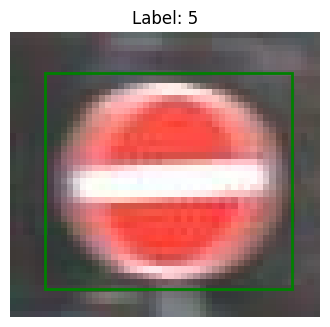

In [24]:
display_image_at_index(train_record, 8000)

## 2. Model

In [17]:
def count_length(df):
    count_images = len(df)
    labels_count = df['Label'].value_counts()

    sorted_labels_count = labels_count.sort_index()
    return sorted_labels_count.tolist(), count_images

In [18]:
def log_model_info(batch, classes, steps, eval_steps, name, bfloat16, pipeline, 
                   checkpoint_path, labelmap, train_record, test_record, config, 
                   trained_model, train_time, df_train, df_test, notes):
    
    
    test_count, test_len = count_length(df_test)
    train_count, train_len = count_length(df_train)   
    log_contents = f"""
Trainingparameters:
    BATCH_SIZE = {batch} # Cannot be higher than 2-4 (lack of ressources)
    NUM_CLASSES = {classes} # Total number of classes to train is 43 - used for training are only 6-7
    NUM_STEPS = {steps}
    NUM_EVAL_STEPS = {eval_steps}
    MODEL_NAME = {name}
    use_bfloat16 = {bfloat16} # Use bfloat16 = True for trainign with TPU
    
Locations: 
    Path to Pipeline-Config = {pipeline}
    Checkpoint from transfermodel  = {checkpoint_path}

    Path to the trainedmodel = {trained_model}
    Config of the trainedmodel = {config}
    
Used records: 
    Used labelmap = {labelmap}
    Used train_record = {train_record}
    Used test_record = {test_record}

Generell Information: 
    Time needed for modeltraining = {train_time}
    Length of traindataset = {train_len}
    Counted values for each Label form Traindataset = {train_count}
    Length of testdataset = {test_len}
    Counted values for each Label form Testdataset = {test_count}
"""

    log_id = uuid.uuid4()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    log_entry = f"ID: {log_id}\nTimestamp: {timestamp}\n\n{log_contents}\nNotes: {notes}\n"

    filename = f"./myModules/log/{name}_{log_id}.txt"
    with open(filename, "a") as file:
        file.write(log_entry)
        file.write("\n" + "="*50 + "\n")

### 2.1 Create training configuration

In [19]:
with open(base_config_path) as f:
    config = f.read()

with open(config_path, 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(base_checkpoint_path), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED)(.*?")', 
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(NUM_CLASSES), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(BATCH_SIZE), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(NUM_STEPS), config)
  
    # Set use_bfloat16
  config = re.sub('use_bfloat16: (true|false)',
                  'use_bfloat16: {}'.format(str(use_bfloat16).lower()), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [20]:
with open(config_path, 'r') as file:
    content = file.read()
    print(content)

model {
  ssd {
    num_classes: 5
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
 

### 2.2 Model Training

In [21]:
start_time = time.time()

!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\model_main_tf2.py \
    --pipeline_config_path={config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_workers=4 \
    --num_train_steps={NUM_STEPS} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={NUM_EVAL_STEPS}

training_time = time.time() - start_time

log_model_info(
    batch=BATCH_SIZE,
    classes=NUM_CLASSES,
    steps=NUM_STEPS,
    eval_steps=NUM_EVAL_STEPS,
    name=MODEL_NAME,
    bfloat16=use_bfloat16,
    pipeline=base_config_path,
    checkpoint_path=base_checkpoint_path,
    labelmap=labelmap_path,
    train_record=train_record_path,
    test_record=test_record_path,
    config=config_path,
    trained_model=model_dir,
    train_time=training_time,
    df_test=df_final_test,
    df_train=df_final_train,
    notes=NOTES
)

c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

### 2.3 Evaluation 

In [15]:
MODEL_NAME = "SSD_16000_640_mobilenet_v2_fpnlite"
config_path = './myModules/configs/{name}_config.config'.format(name=MODEL_NAME)
model_dir = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'.format(name=MODEL_NAME)

In [23]:
command = f"python C:\\Users\\Alexej\\Desktop\\GTSRB\\models\\research\\object_detection\\model_main_tf2.py \
            --pipeline_config_path={config_path} \
            --model_dir={model_dir} \
            --checkpoint_dir={model_dir}"

In [24]:
print(f"Evaluating model: {MODEL_NAME}")
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
output, error = process.communicate()
print(f"Done Evaluating: {MODEL_NAME}")
if process.returncode != 0:
    print(error.decode("utf-8"))
else:
    print(f"No Error: {MODEL_NAME}")
    output_str = output.decode("utf-8")
    header = f"Evaluation Results for: {MODEL_NAME}\n\n"
    with open(f"./myModules/log/{MODEL_NAME}_evaluation_results.txt", "w") as f:
        f.write(header)
        f.write(output_str)

Evaluating model: SSD_8000_640_mobilenet_v2_fpnlite
Done Evaluating: SSD_8000_640_mobilenet_v2_fpnlite
No Error: SSD_8000_640_mobilenet_v2_fpnlite


In [ ]:
"SSD_8000_640_mobilenet_v1_fpn_custom" # Bugged
"SSD_8000_640_mobilenet_v1_fpn"
"SSD_8000_640_mobilenet_v2_fpnlite_custom"

In [10]:
model_names = [
    "SSD_8000_640_resnet101_v1_fpn",
    "SSD_16000_640_mobilenet_v2_fpnlite"
]

config_template = './myModules/configs/{name}_config.config'
model_dir_template = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'
log_dir = './myModules/log'


os.makedirs(log_dir, exist_ok=True)

def evaluate_model(model_name):
    config_path = config_template.format(name=model_name)
    model_dir = model_dir_template.format(name=model_name)
    
    command = f"python C:\\Users\\Alexej\\Desktop\\GTSRB\\models\\research\\object_detection\\model_main_tf2.py \
                --pipeline_config_path={config_path} \
                --model_dir={model_dir} \
                --checkpoint_dir={model_dir}"
    
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()

    if process.returncode != 0:
        error_message = error.decode("utf-8")
        print(f"Error evaluating model {model_name}: {error_message}")
        return error_message
    else:
        output_str = output.decode("utf-8")
        header = f"Evaluation Results for: {model_name}\n\n"
        result_file = os.path.join(log_dir, f"{model_name}_evaluation_results.txt")
        with open(result_file, "w") as f:
            f.write(header)
            f.write(output_str)
        print(f"Evaluation results for {model_name} saved to {result_file}")
        return output_str

# Hauptschleife zur Evaluierung der Modelle
for model_name in model_names:
    print(f"Evaluating model: {model_name}")
    evaluate_model(model_name)

Evaluating model: SSD_8000_640_resnet101_v1_fpn


In [13]:
# Lade die Evaluierungsdaten
eval_dataset = tf.data.TFRecordDataset(test_record_path)

# Zähle die Anzahl der Elemente (Frames) im Dataset
num_frames = sum(1 for _ in eval_dataset)
print(f"Anzahl der Frames: {num_frames}")

total_time = 17.09 + 10.86  # Gesamtzeit in Sekunden

# Durchschnittliche Zeit pro Frame
time_per_frame = total_time / num_frames

# FPS
fps = 1 / time_per_frame
print(f"FPS: {fps:.2f}")

NameError: name 'test_record_path' is not defined

In [ ]:
def evaluate_checkpoints(config_path, model_dir, checkpoints, model_name):
    """Evaluates all checkpoints and logs the results."""
    for checkpoint in checkpoints:
        eval_command = f"python C:/Users/Alexej/Desktop/GTSRB/models/research/object_detection/model_main_tf2.py \
            --pipeline_config_path={config_path} \
            --model_dir={model_dir} \
            --checkpoint_dir={checkpoint} \
            --run_once"

        # Starte den Evaluierungsprozess
        process = subprocess.Popen(eval_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
        output, error = process.communicate()

        if process.returncode != 0:
            print(f"Error evaluating checkpoint {checkpoint}:")
            print(error.decode("utf-8"))
        else:
            output_str = output.decode("utf-8")
            checkpoint_name = os.path.basename(checkpoint)
            header = f"Evaluation Results for MODEL_NAME: {model_name} at Checkpoint: {checkpoint_name}\n\n"
            with open(f"./myModules/log/{model_name}_evaluation_results_{checkpoint_name}.txt", "w") as f:
                f.write(header)
                f.write(output_str)
            print(f"Evaluation for checkpoint {checkpoint} completed.")

In [ ]:
checkpoints = get_checkpoints(model_dir)

evaluate_checkpoints(config_path, model_dir, checkpoints, MODEL_NAME)

## 3. Inference

### 3.0 Setup 

In [25]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [9]:
def run_inference_for_multiple_images(model, image, min_score_threshold):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Filter out detections with a score below the threshold
    scores = output_dict['detection_scores']
    high_score_indices = scores >= min_score_threshold

    output_dict['detection_boxes'] = output_dict['detection_boxes'][high_score_indices]
    output_dict['detection_classes'] = output_dict['detection_classes'][high_score_indices]
    output_dict['detection_scores'] = output_dict['detection_scores'][high_score_indices]

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [10]:
def load_image_into_numpy_array(path, width, height):
    image = Image.open(path)
    # Resize the image to a larger size
    image = image.resize((width, height))  # Resize to 256x256, you can change this as needed
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [11]:
def visualize_boxes_with_color(image, boxes, classes, scores, category_index, box_color, line_thickness):
    for i in range(boxes.shape[0]):
        if scores is None or scores[i] > 0.5:
            class_id = int(classes[i])
            if class_id in category_index.keys():
                class_name = category_index[class_id]['name']
                display_str = str(class_name)
                color = box_color
                vis_util.draw_bounding_box_on_image_array(
                    image,
                    boxes[i][0],
                    boxes[i][1],
                    boxes[i][2],
                    boxes[i][3],
                    color=color,
                    thickness=line_thickness,
                    display_str_list=[display_str],
                    use_normalized_coordinates=True)

In [12]:
def add_legend(image, groundtruth_classes, category_index, iou):
    draw = ImageDraw.Draw(image)
    image_height = image.size[1]
    font_size = max(int(image_height * 0.04), 12)  # Schriftgröße auf 4% der Bildhöhe begrenzt, aber mindestens 12
    font = ImageFont.truetype("arial.ttf", size=font_size)

    y_offset = int(0.9 * image_height)  # Startoffset für die Legende, z.B. 90% der Bildhöhe
    x_offset = int(0.05 * image.size[0])  # Startoffset für die Legende, z.B. 5% der Bildbreite

    # Ground Truth Legende
    for gt_class in groundtruth_classes:
        if gt_class in category_index:
            class_name = category_index[gt_class]['name']
            draw.text((x_offset, y_offset), f"GT: {class_name}\nIoU: {iou:.2f}", fill="yellow", font=font)
            y_offset += int(font_size * 1.5)  # Erhöhe den Offset basierend auf der aktuellen Schriftgröße

In [13]:
def compute_iou(boxA, boxB):
    yA = max(boxA[0], boxB[0])
    xA = max(boxA[1], boxB[1])
    yB = min(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [14]:
def visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index):
    # Visualize ground truth with red color
    visualize_boxes_with_color(
        image_np,
        np.array(groundtruth_boxes),
        np.array(groundtruth_classes),
        np.ones(len(groundtruth_boxes)),
        category_index,
        box_color='red',
        line_thickness=1)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    
    iou = compute_iou(groundtruth_boxes[0], output_dict['detection_boxes'][0])
    
    image_pil = Image.fromarray(np.uint8(image_np)).convert("RGB")
    add_legend(image_pil, groundtruth_classes, category_index, iou)
    display(image_pil)

In [15]:
def visualize_predictions_and_groundtruth_plot(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index, ax):
    # Visualize ground truth with red color
    visualize_boxes_with_color(
        image_np,
        np.array(groundtruth_boxes),
        np.array(groundtruth_classes),
        np.ones(len(groundtruth_boxes)),
        category_index,
        box_color='red',
        line_thickness=1)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    
    iou = compute_iou(groundtruth_boxes[0], output_dict['detection_boxes'][0])
    ax.imshow(image_np)
    ax.axis('off')  # Hide the axis

    # Adding legend to the plot
    label_text = category_index[groundtruth_classes[0]]['name']
    ax.set_title(f'{label_text}\nIoU: {iou:.2f}')

In [16]:
def visualize_random_images_for_labels(df, model, category_index, discard_predictions_below_acc, num_images_to_display):
    sorted_labels = sorted(df['Label'].unique())

    num_rows = len(sorted_labels)
    num_cols = num_images_to_display

    _, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols + num_cols * 0.5, num_rows * 2))
    
    if num_rows == 1:
        axes = axes.reshape(1, num_cols)
    else:
        axes = axes.flatten()

    for idx, label in enumerate(sorted_labels):
        label_df = df[df['Label'] == label]
        
        random_indices = random.sample(range(len(label_df)), min(num_images_to_display, len(label_df)))

        for jdx, r_idx in enumerate(random_indices):
            row = label_df.iloc[r_idx]
            image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
            groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
            groundtruth_classes = [row['Label']]
            
            output_dict = run_inference_for_multiple_images(model, image_np, discard_predictions_below_acc)
            
            plot_idx = idx * num_images_to_display + jdx
            
            visualize_predictions_and_groundtruth_plot(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index, axes[plot_idx])
    
    plt.tight_layout()
    plt.show()

In [17]:
def plot_random_predictions_with_groundtruth (model, df, num_images_to_display, category_index):
    
    random_indices = random.sample(range(len(df)), num_images_to_display)

    # Visualisiere zufällige ausgewählte Bilder
    for idx in random_indices:
        row = df.iloc[idx]
        image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
        groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
        groundtruth_classes = [row['Label']]
        
        output_dict = run_inference_for_single_image(model, image_np)
        visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index)

In [18]:
def plot_endless_predictions(model, df, category_index):
    
    for _, row in df.iterrows():
        image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
        groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
        groundtruth_classes = [row['Label']]
        
        output_dict = run_inference_for_single_image(model, image_np)
        visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index)

In [19]:
def plot_simple_endless_predictions_from_path(model, path, category_index):
    
    for image_path in glob.glob(path):
        image_np = load_image_into_numpy_array(image_path, IMAGE_WIDTH, IMAGE_HEIGHT)
        output_dict = run_inference_for_single_image(model, image_np)
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks_reframed', None),
            use_normalized_coordinates=True,
            line_thickness=1)
        display(Image.fromarray(image_np))

### 3.1 Inference 

In [ ]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --inference_path {inference_path} \
    --config_path {config_path}

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [ ]:
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'./{inference_path}/saved_model')

### 3.2 Inference Plots 

In [ ]:
%matplotlib inline

image_path = './GTSRB/Final_Test/Images/*.ppm'
min_score_threshold = 0.6
number_of_images_to_display = 10

In [ ]:
plot_simple_endless_predictions_from_path(model, image_path, category_index)

In [ ]:
plot_endless_predictions(model, df_final_test, category_index)

In [ ]:
plot_random_predictions_with_groundtruth(model, df_final_test, number_of_images_to_display, category_index)

In [ ]:
visualize_random_images_for_labels(df_final_test, model, category_index, min_score_threshold, number_of_images_to_display)

## 4. Evaluation (discarded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
all_true_labels = []
all_predicted_labels = []

for idx, row in df_test_raw.iterrows():
    row = df_test_raw.iloc[idx]
    image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
    groundtruth_classes = [row['Label']]
    
    output_dict = run_inference_for_single_image(model, image_np)
    
    predicted_class = output_dict['detection_classes'][0]
    all_predicted_labels.append(predicted_class)
    all_true_labels.append(groundtruth_classes[0])

In [ ]:
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

In [ ]:
cm = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Vorhersage')
plt.ylabel('Wahre Werte')
plt.title('Konfusionsmatrix')
plt.show()

print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

## 5. Real-Time detection

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(TRAINED_CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(TRAINED_CHECKPOINT_PATH, 'ckpt-8')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(TRAINED_LABLE_MAP_PATH, use_display_name=True)

In [ ]:
tf.keras.backend.clear_session()
model = tf.saved_model.load('./inference/faster_rcnn/Faster_RCNN_640_50_fixed/saved_model')

In [ ]:
# Funktion zum Laden des Modells
def load_model(model_path):
    saved_model = tf.saved_model.load(model_path)
    return saved_model

# Beispielaufruf der Funktion
model_path = './inference/faster_rcnn/Faster_RCNN_640_50_fixed/saved_model'
detection_model = load_model(model_path)

In [ ]:
# Funktion zum Erstellen des Detektionsmodells und Wiederherstellen des Checkpoints
def load_model():
    configs = tf.compat.v2.saved_model.load('./inference/faster_rcnn/Faster_RCNN_640_50_fixed/saved_model')
    return configs['model']

detection_model = load_model()

In [ ]:
cap = cv2.VideoCapture(0)
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_util.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.9,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 800)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        break
cap.release()

### Video capture testing

In [ ]:
# Pfad zum Eingabevideo und zum Ausgabevideo
input_video_path = 'path_to_your_video.mp4'
output_video_path = 'path_to_output_video.mp4'

# VideoCapture-Objekt erstellen
cap = cv2.VideoCapture(input_video_path)

# Überprüfen, ob das Video geöffnet werden kann
if not cap.isOpened():
    print("Error opening video stream or file")

# Video-Eigenschaften abrufen
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# VideoWriter-Objekt erstellen
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    
    # Beenden der Schleife, wenn das Video zu Ende ist
    if not ret:
        break

    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes sollten ints sein.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_util.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.9,
                agnostic_mode=False)

    # Frame mit Detektionen in das Ausgabevideo schreiben
    out.write(image_np_with_detections)

    # Optional: Zeige das Video mit Detektionen in einem Fenster an
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 800)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Ressourcen freigeben
cap.release()
out.release()
cv2.destroyAllWindows()

Video capture testing end

In [ ]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Laden der Label Map
category_index = label_map_util.create_category_index_from_labelmap(TRAINED_LABLE_MAP_PATH)

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Konvertieren des Frames zu einem Tensor
    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, axis=0), dtype=tf.float32)
    
    # Durchführung der Objekterkennung
    detections = detect_fn(input_tensor)
    
    # Verarbeitung der erkannten Objekte
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # Visualisierung der erkannten Objekte auf dem Frame
    viz_util.visualize_boxes_and_labels_on_image_array(
        frame,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,  # Anzahl der maximal zu zeichnenden Boxen
        min_score_thresh=0.5    # Minimale Vertrauensschwelle für die Anzeige
    )

    # Anzeigen des Frames mit den erkannten Objekten
    cv2.imshow('Object Detection', frame)
    
    # Stoppen der Erfassung bei Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [ ]:

# Laden und Konfigurieren des Modells
configs = config_util.get_configs_from_pipeline_file(TRAINED_CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Wiederherstellen des Checkpoints
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(TRAINED_CHECKPOINT_PATH, 'ckpt-9')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Laden der Label Map
category_index = label_map_util.create_category_index_from_labelmap(TRAINED_LABLE_MAP_PATH)

# Videoaufnahme starten
cap = cv2.VideoCapture(0)
while True: 
    ret, frame = cap.read()
    if not ret:
        break
    
    # Überprüfen der Form des Bildes
    if len(frame.shape) == 2:  # Falls das Bild ein Graustufenbild ist
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    
    # Konvertieren des Frames zu einem Tensor
    image_np = np.array(frame)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # Durchführung der Objekterkennung
    detections = detect_fn(input_tensor)
    
    # Verarbeitung der erkannten Objekte
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # Visualisierung der erkannten Objekte auf dem Frame
    viz_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        detections['detection_boxes'],
        detections['detection_classes']+1,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=0.9,
        agnostic_mode=False
    )

    # Anzeigen des Frames mit den erkannten Objekten
    cv2.imshow('Object Detection', cv2.resize(image_np, (800, 800)))
    
    # Stoppen der Erfassung bei Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:


# Videoaufnahme von der Kamera starten (Kamera 0)
cap = cv2.VideoCapture(0)

# Überprüfen, ob die Kamera erfolgreich geöffnet wurde
if not cap.isOpened():
    print("Fehler beim Öffnen der Kamera")
    exit()

# Unendlich Schleife, um Frames von der Kamera zu lesen und anzuzeigen
while True:
    # Lesen eines einzelnen Frames von der Kamera
    ret, frame = cap.read()
    
    # Überprüfen, ob das Frame erfolgreich gelesen wurde
    if not ret:
        print("Fehler beim Lesen des Frames")
        break
    
    # Anzeigen des Frames in einem Fenster
    cv2.imshow('Videoaufnahme', frame)
    
    # Beenden der Schleife bei Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Freigeben der Videoquelle und Schließen aller Fenster
cap.release()
cv2.destroyAllWindows()

## Worked

In [20]:
TRAINED_CONFIG_PATH = "./myModules/configs/Faster_RCNN_640_50_fixed_config.config"
TRAINED_CHECKPOINT_PATH = 'D:\\Desktop-Short\\trained_models\\faster_rcnn\\Faster_RCNN_640_50_fixed'
TRAINED_LABLE_MAP_PATH = "./myModules/label_map_short.pbtxt"

In [55]:
configs = config_util.get_configs_from_pipeline_file(TRAINED_CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Wiederherstellen des Checkpoints
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(TRAINED_CHECKPOINT_PATH, 'ckpt-9')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Laden der Label Map
category_index = label_map_util.create_category_index_from_labelmap(TRAINED_LABLE_MAP_PATH)

In [56]:
def run_inference_for_single_image(image):
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image, 0), dtype=tf.float32)
    #input_tensor = input_tensor[tf.newaxis,...]
    output_dict = detect_fn(input_tensor)
    
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [72]:
def show_inference(frame):
    
    image_np = np.array(frame)
    output_dict = run_inference_for_single_image(image_np)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes']+1,
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        max_boxes_to_draw=10,
        min_score_thresh=0.6,
        agnostic_mode=False,
        line_thickness=5)
    return image_np

In [63]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
           
    if len(frame.shape) == 2:  
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        
    frame_with_detections = show_inference(frame)
    
    cv2.imshow('Object Detection', frame_with_detections)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [73]:
# Zugriff auf die Kamera (0 für die Standardkamera)
cap = cv2.VideoCapture(0)

# Variablen zur FPS-Berechnung
frame_count = 0
start_time = time.time()
fps = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Führe die Objekterkennung durch
    frame_with_detections = show_inference(frame)

    # Berechne die FPS
    frame_count += 1
    if (time.time() - start_time) > 1:  # Ein Sekundenintervall
        fps = frame_count / (time.time() - start_time)
        frame_count = 0
        start_time = time.time()

    # Zeige die FPS auf dem Frame
    cv2.putText(frame_with_detections, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Zeige den Frame mit den Erkennungsergebnissen
    cv2.imshow('Object Detection', frame_with_detections)

    # Beenden durch Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release der Kamera und Schließen aller Fenster
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Kamera-Kalibrierungsparameter (müssen angepasst werden)
f = 800  # Brennweite in Pixeln
objekt_breite = 0.5  # tatsächliche Breite des Objekts in Metern

# Videoaufnahme starten
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Überprüfen der Form des Bildes
    if len(frame.shape) == 2:  # Falls das Bild ein Graustufenbild ist
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

    # Konvertieren des Frames zu einem Tensor
    image_np = np.array(frame)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    # Durchführung der Objekterkennung
    detections = detect_fn(input_tensor)

    # Verarbeitung der erkannten Objekte
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # Entfernung berechnen und Ergebnisse anpassen
    for i in range(num_detections):
        box = detections['detection_boxes'][i]
        ymin, xmin, ymax, xmax = box
        box_width = xmax - xmin
        box_height = ymax - ymin

        # Berechne die Größe des Objekts in Pixeln
        box_width_pixels = box_width * frame.shape[1]
        box_height_pixels = box_height * frame.shape[0]

        # Berechne die Entfernung zum Objekt (angenommene Größe des Objekts)
        entfernung = (objekt_breite * f) / box_width_pixels

        # Hier kannst du die Erkennungsergebnisse basierend auf der Entfernung anpassen
        # Beispiel: Du kannst die Boxen oder Scores basierend auf der Entfernung anpassen

    # Visualisierung der erkannten Objekte auf dem Frame
    vis_util.visualize_boxes_and_labels_on_image_array(
        frame,
        detections['detection_boxes'],
        detections['detection_classes'] + 1,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=0.3,
        agnostic_mode=False
    )

    # Anzeigen des Frames mit den erkannten Objekten
    cv2.imshow('Object Detection', frame)

    # Stoppen der Erfassung bei Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# Videoaufnahme starten
cap = cv2.VideoCapture(0)

# Definiere Skalierungsfaktoren
scales = [0.25, 1.0, 1.5]

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Überprüfen der Form des Bildes
    if len(frame.shape) == 2:  # Falls das Bild ein Graustufenbild ist
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

    # Initialisiere eine Liste, um alle Erkennungen zu speichern
    all_detections = []

    for scale in scales:
        # Skaliere das Bild
        height, width, _ = frame.shape
        new_size = (int(width * scale), int(height * scale))
        resized_frame = cv2.resize(frame, new_size)

        # Konvertieren des Frames zu einem Tensor
        image_np = np.array(resized_frame)
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

        # Durchführung der Objekterkennung
        detections = detect_fn(input_tensor)

        # Verarbeitung der erkannten Objekte
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        detections['num_detections'] = num_detections
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        # Berechne die Skalierungskorrektur für die Box-Koordinaten
        height_scale = height / new_size[1]
        width_scale = width / new_size[0]
        detections['detection_boxes'][:, [0, 2]] *= height_scale
        detections['detection_boxes'][:, [1, 3]] *= width_scale

        # Speichere die Ergebnisse
        all_detections.append(detections)

    # Kombiniere alle Erkennungen
    # Du kannst hier die Detections nach deinem Bedarf kombinieren oder zusammenführen

    # Verwende die Detections von der letzten Skala für die Visualisierung (oder alle)
    final_detections = all_detections[-1]  # Hier nehmen wir die Erkennung von der letzten Skala

    # Visualisierung der erkannten Objekte auf dem Frame
    vis_util.visualize_boxes_and_labels_on_image_array(
        frame,
        final_detections['detection_boxes'],
        final_detections['detection_classes'] + 1,
        final_detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=0.3,
        agnostic_mode=False
    )

    # Anzeigen des Frames mit den erkannten Objekten
    cv2.imshow('Object Detection', frame)

    # Stoppen der Erfassung bei Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [59]:

# Videoaufnahme starten
cap = cv2.VideoCapture(0)
while True: 
    ret, frame = cap.read()
    if not ret:
        break
    
    # Überprüfen der Form des Bildes
    if len(frame.shape) == 2:  # Falls das Bild ein Graustufenbild ist
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    
    # Konvertieren des Frames zu einem Tensor
    image_np = np.array(frame)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # Durchführung der Objekterkennung
    detections = detect_fn(input_tensor)
    
    # Verarbeitung der erkannten Objekte
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # Visualisierung der erkannten Objekte auf dem Frame
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        detections['detection_boxes'],
        detections['detection_classes']+1,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=0.3,
        agnostic_mode=False
    )

    # Anzeigen des Frames mit den erkannten Objekten
    cv2.imshow('Object Detection', cv2.resize(image_np, (640, 640)))
    
    # Stoppen der Erfassung bei Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:

cap = cv2.VideoCapture(0)
while True: 
    ret, frame = cap.read()
    if not ret:
        break
    
    # Skalieren des Frames auf 640x640
    frame_resized = cv2.resize(frame, (640, 640))
    
    # Überprüfen der Form des Bildes
    if len(frame_resized.shape) == 2:  # Falls das Bild ein Graustufenbild ist
        frame_resized = cv2.cvtColor(frame_resized, cv2.COLOR_GRAY2RGB)
    
    # Konvertieren des Frames zu einem Tensor
    image_np = np.array(frame_resized)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # Durchführung der Objekterkennung
    detections = detect_fn(input_tensor)
    
    # Verarbeitung der erkannten Objekte
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # Visualisierung der erkannten Objekte auf dem Frame
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        detections['detection_boxes'],
        detections['detection_classes']+1,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=0.9,
        agnostic_mode=False
    )

    # Anzeigen des Frames mit den erkannten Objekten
    cv2.imshow('Object Detection', cv2.resize(image_np, (800, 800)))
    
    # Stoppen der Erfassung bei Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# Videoaufnahme starten
cap = cv2.VideoCapture(0)
while True: 
    ret, frame = cap.read()
    if not ret:
        break
    
    # Skalieren des Frames auf die Eingabegröße des Modells (640x640)
    frame_resized = cv2.resize(frame, (640, 640))
    
    # Überprüfen der Form des Bildes
    if len(frame_resized.shape) == 2:  # Falls das Bild ein Graustufenbild ist
        frame_resized = cv2.cvtColor(frame_resized, cv2.COLOR_GRAY2RGB)
    
    # Konvertieren des Frames zu einem Tensor
    image_np = np.array(frame_resized)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # Durchführung der Objekterkennung
    detections = detect_fn(input_tensor)
    
    # Verarbeitung der erkannten Objekte
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # Skalieren der Bounding Boxes auf die Originalgröße des Frames
    h, w, _ = frame.shape
    scale_x, scale_y = w / 640, h / 640
    
    detections['detection_boxes'][:, 0] *= h  # ymin
    detections['detection_boxes'][:, 1] *= w  # xmin
    detections['detection_boxes'][:, 2] *= h  # ymax
    detections['detection_boxes'][:, 3] *= w  # xmax
    
    # Visualisierung der erkannten Objekte auf dem Frame
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        detections['detection_boxes'],
        detections['detection_classes']+1,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=False,  # Normalisierte Koordinaten nicht mehr verwenden
        max_boxes_to_draw=10,
        min_score_thresh=0.9,
        agnostic_mode=False
    )

    # Anzeigen des Frames mit den erkannten Objekten
    cv2.imshow('Object Detection', cv2.resize(image_np, (800, 800)))
    
    # Stoppen der Erfassung bei Drücken der 'q'-Taste
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 6. TFLite for Jetson 

In [22]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\export_tflite_graph_tf2.py \
    --pipeline_config_path={config_path} \
    --trained_checkpoint_dir={TRAINED_CHECKPOINT_PATH} \
    --output_directory={model_dir}

2024-07-24 14:57:40.540812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 14:57:40.640632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
I0724 14:57:54.295555 21352 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
2024-07-24 14:57:58.380026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-07-24 14:57:58

In [43]:
FROZEN_TFLITE_PATH = os.path.join(model_dir, 'saved_model')
TFLITE_MODEL = os.path.join(model_dir, 'saved_model', 'detect.tflite')

In [52]:
print(saved_model_dir, TFLITE_MODEL)
D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model

D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model\ D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model\detect.tflite


In [60]:
saved_dir = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}\\saved_model\\'.format(name=MODEL_NAME)
tflite_model_dir = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}\\saved_model\\detect.tflite'.format(name=MODEL_NAME)

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops

In [55]:
!tflite_convert --saved_model_dir=saved_model_dir --output_file=tflite_model_dir

Traceback (most recent call last):
  File "C:\Users\Alexej\miniconda3\envs\tf-keras\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Alexej\miniconda3\envs\tf-keras\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Alexej\miniconda3\envs\tf-keras\Scripts\tflite_convert.exe\__main__.py", line 7, in <module>
  File "C:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow\lite\python\tflite_convert.py", line 692, in main
    app.run(main=run_main, argv=sys.argv[:1])
  File "C:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\absl\app.py", line 308, in run
    _run_main(main, args)
  File "C:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\absl\app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "C:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow\lite\python\tflite_convert.py", line 675, in run_main
    _convert_tf2_model(tflite_flags)
 

In [57]:
output_directory = 'tf_lite'

!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\export_tflite_graph_tf2.py \
    --trained_checkpoint_dir={TRAINED_CHECKPOINT_PATH} \
    --output_directory={output_directory} \
    --pipeline_config_path={config_path}

2024-07-24 15:28:29.020734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 15:28:29.135414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
I0724 15:28:35.269696  8296 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
2024-07-24 15:28:39.181165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-07-24 15:28:39

In [62]:
!tflite_convert --saved_model_dir=D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model\ --output_file=D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model\model.tflite

Estimated count of arithmetic ops: 219.390 G  ops, equivalently 109.695 G  MACs


2024-07-24 15:33:24.241856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 15:33:24.298424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-07-24 15:33:41.946710: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-07-24 15:33:41.947009: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-07-24 15:33:41.947927: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: D:\Desktop-Short\trained_models\ssd\ssd_tes

In [64]:
print(tflite_model_dir, saved_model_dir)

D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model\detect.tflite D:\Desktop-Short\trained_models\ssd\ssd_test\saved_model\


In [ ]:
!tflite_convert --saved_model_dir=saved_model_dir --output_file=tflite_model_dir